In [3]:
import os
import requests

from langchain_experimental.text_splitter import SemanticChunker
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_classic.tools.retriever import create_retriever_tool
from langchain_classic import hub
from langchain.agents import create_agent
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [4]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})

In [16]:
def create_pdf_retriever(
        pdf_path: str,
        persist_directory: str,
        embedding_model
) -> Chroma.as_retriever:
    loader = PyMuPDFLoader(pdf_path)
    docs = loader.load()
    full_text = '\n\n'.join(doc.page_content for doc in docs)
    text_splitter = SemanticChunker(embeddings=embedding_model)
    docs = text_splitter.create_documents([full_text])
    for doc in docs:
        doc.metadata['source'] = pdf_path
    
    vectorstore = Chroma.from_documents(
        persist_directory=persist_directory, documents=docs, embedding=embedding_model
    )

    return vectorstore.as_retriever()

In [17]:
japan_path = './data/ict_japan_2024.pdf'
usa_path = './data/ict_usa_2024.pdf'
japan_db_path = './data/db_ict_policy_japan_2024'
usa_db_path = './data/db_ict_policy_usa_2024'

In [18]:
retreiver_japan = create_pdf_retriever(
    pdf_path=japan_path,
    persist_directory=japan_db_path,
    embedding_model=embeddings
)
retreiver_japan

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x00000262AE772CF0>, search_kwargs={})

In [19]:
retriever_usa = create_pdf_retriever(
    pdf_path=usa_path,
    persist_directory=usa_db_path,
    embedding_model=embeddings
)
retriever_usa

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002634217D450>, search_kwargs={})

In [20]:
jp_engine = create_retriever_tool(
    retriever=retreiver_japan,
    name='japan_ict',
    description='일본의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

usa_engine = create_retriever_tool(
    retriever=retriever_usa,
    name='usa_ict',
    description='미국의 ICT 시장 동향 정보를 제공합니다. 일본 ICT와 관련된 질문은 해당 도구를 사용하세요.'
)

tools = [jp_engine, usa_engine]

In [21]:
prompt_react = hub.pull('hwchase17/react')
print(prompt_react.template)
print('--prompt end--')

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
--prompt end--


In [22]:
template = '''다음 질문에 최선을 다해 답변하세요. 당신은 다음 도구들에 접근할 수 있습니다:

{tools}

다음 형식을 사용하세요:

Question: 답변해야 하는 입력 질문
Thought: 무엇을 할지 항상 생각하세요
Action: 취해야 할 행동, [{tool_names}] 중 하나여야 합니다. 리스트에 있는 도구 중 1개를 택하십시오.
Action Input: 행동에 대한 입력값
Observation: 행동의 결과
... (이 Thought/Action/Action Input/Observation의 과정이 N번 반복될 수 있습니다)
Thought: 이제 최종 답변을 알겠습니다
Final Answer: 원래 입력된 질문에 대한 최종 답변

## 추가적인 주의사항
- 반드시 [Thought -> Action -> Action Input format] 이 사이클의 순서를 준수하십시오. 항상 Action 전에는 Thought가 먼저 나와야 합니다.
- 최종 답변에는 최대한 많은 내용을 포함하십시오.
- 한 번의 검색으로 해결되지 않을 것 같다면 문제를 분할하여 푸는 것은 중요합니다.
- 정보가 취합되었다면 불필요하게 사이클을 반복하지 마십시오.
- 묻지 않은 정보를 찾으려고 도구를 사용하지 마십시오.

시작하세요!

Question: {input}
Thought: {agent_scratchpad}'''

prompt = PromptTemplate.from_template(template)

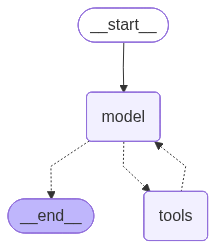

In [ ]:
llm = ChatOpenAI(model='gpt-5-mini', temperature=0)
checkpointer = MemorySaver()

agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=template,
    #checkpointer=checkpointer,
)
agent